In [1]:
import os
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import sobel
from scipy.ndimage import gaussian_filter

from skimage.feature import canny
from skimage.filters import median
from skimage.restoration import denoise_bilateral

from skimage.filters import prewitt_h, prewitt_v

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

scaler = StandardScaler()

import joblib

In [35]:
# ref : https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/#gsc.tab=0
def downsample_image(img):
    scale_percent = 20 
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized
 
def upsample_image(img):   # To be used after prediction
    scale_percent = 500
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    gray_img = cv2.resize(gray_img, (960, 999))
    
    # check if size is correct 
    # 1) Convert to gray scale
    # 2) Normalize 
    # 3) Downsample image by 50%
    
#     if(img.shape[0] != 960):
#         print("Change shape")
    
    final_img = gray_img/255
    final_img = downsample_image(gray_img)
    
    return final_img

def preprocess_seg_map(seg_path):
    # reading array 
    seg_map = cv2.imread(seg_path,cv2.IMREAD_GRAYSCALE)
    
    target_size = (960, 999)
    seg_map = resize_and_threshold(seg_map, target_size)
    
    # Convert from bool to uint8
    seg_map = seg_map.astype(np.uint8)
    # convert the max value pixel to 1 (To create a binary seg map)
    seg_map[seg_map == 255] = 1
        
    # Downsample the seg_map by 50%
    seg_map = downsample_image(seg_map)
    return seg_map

def extract_features_test(gray_img):
    radius = 1
    entropy_img = entropy(gray_img,disk(radius))
    sigma = 5  
    gauss_image = gaussian_filter(gray_img, sigma=sigma) #### (APPLIED ON COLOR ORIGINALLY)
    sobel_filtered = sobel(gray_img) 
    edges = canny(gray_img)
    median_filtered = median(gray_img)                               ##### (APPLIED ON COLOR ORIGINALLY)
    bilateral_filtered = denoise_bilateral(gray_img,channel_axis=-1,multichannel=False) ##### (APPLIED ON COLOR ORIGINALLY)
    prewitt_horizontal = prewitt_h(gray_img)
    prewitt_vertical = prewitt_v(gray_img)
    
    pixel_feature = gray_img.reshape(-1).reshape(-1, 1)                        #1
    entropy_feature = entropy_img.reshape(-1).reshape(-1, 1)                   #2
    gauss_feature = gauss_image.reshape(-1).reshape(-1, 1)                     #3
    sobel_feature = sobel_filtered.reshape(-1).reshape(-1, 1)                  #4
    edges_feature = edges.reshape(-1).reshape(-1, 1)                           #5
    median_feature = median_filtered.reshape(-1).reshape(-1, 1)                #6
    bilateral_feature = bilateral_filtered.reshape(-1).reshape(-1, 1)          #7
    prewitt_horizontal_feature = prewitt_horizontal.reshape(-1).reshape(-1, 1) #8
    prewitt_vertical_feature = prewitt_vertical.reshape(-1).reshape(-1, 1)     #9
        
    feature_matrix = np.hstack((pixel_feature,entropy_feature,gauss_feature,
                               sobel_feature,edges_feature,median_feature,
                               bilateral_feature,prewitt_horizontal_feature,
                               prewitt_vertical_feature))
    return feature_matrix

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    
    if union == 0:
        return 1.0 
    dice = (2.0 * intersection) / union
    return dice

def are_binary_arrays(arr1, arr2):
    return np.all(np.isin(arr1, [0, 1])) and np.all(np.isin(arr2, [0, 1]))

def print_unique_values(arr):
    unique_values = np.unique(arr)
    print("Unique values in the array:", unique_values)
    
def resize_and_threshold(image, target_size):
    resized_image = cv2.resize(image, target_size)

    _, thresholded_image = cv2.threshold(resized_image, 127, 255, cv2.THRESH_BINARY)

    return thresholded_image

In [29]:
clf = joblib.load('Trained_model_checkpoints/TM_3_301223_without_scaler_with_SMOTE_14Image_1%train.pkl')
print(clf)

weights = clf.coef_
intercept = clf.intercept_

print("Coefficients (Weights):", weights)
print("Intercept:", intercept)

SVC(C=0.001, cache_size=7000, gamma=0.0001, kernel='linear', verbose=True)
Coefficients (Weights): [[-0.31836757  0.88071982  0.09835305  0.03271017  0.17856991  0.22361774
   0.04153331 -0.00650219 -0.01140142]]
Intercept: [-2.18061329]


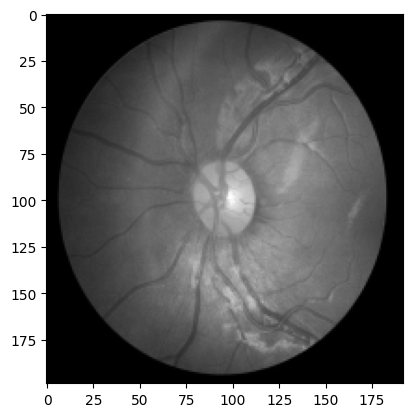

C:\Users\RITWIK KASHYAP\AppData\Local\Temp\ipykernel_25468\3238579569.py:63: FutureWarning: `multichannel` is a deprecated argument name for `denoise_bilateral`. It will be removed in version 1.0. Please use `channel_axis` instead.
  bilateral_filtered = denoise_bilateral(gray_img,channel_axis=-1,multichannel=False) ##### (APPLIED ON COLOR ORIGINALLY)


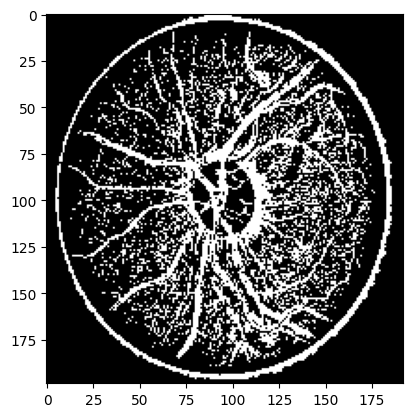

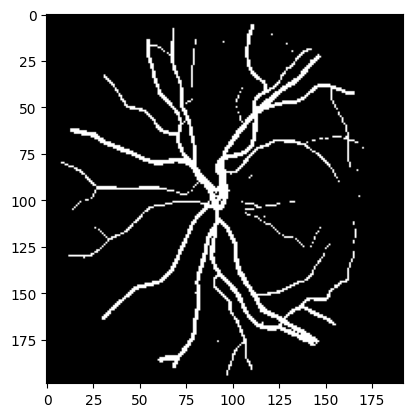

Both arrays contain only 0s and 1s.
Unique values in the array: [0 1]
Unique values in the array: [0. 1.]
Dice score for segmentation :  0.37622309197651665


In [36]:
# test_image = "General_test_image.jpg"
test_image = "IMAGES/Image_02L.jpg"
test_ans = "SEG1/Image_02L_1stHO.png"

img = preprocess_image(test_image)
seg = preprocess_seg_map(test_ans)

true_map = seg
seg = seg.reshape(-1)

plt.imshow(img,cmap = 'gray')
plt.show()

# print(img.shape)
# print(true_map.shape)

fea_matrix = extract_features_test(img)
fea_matrix_scaled = scaler.fit_transform(fea_matrix)

# print(fea_matrix.shape)

# # Predict the labels by 
ypred = clf.predict(fea_matrix)

# print(ypred.shape)
# # Count the number of 1s and 0s
# count_zeros = np.count_nonzero(ypred == 0)
# count_ones = np.count_nonzero(ypred == 1)

# # print("Number of zeros:", count_zeros)
# # print("Number of ones:", count_ones)

# Convert this ypred (1D array) to INPUT_SIZE_USER or (first to AxB then upsample to INPUT_SIZE (If preprocess done))
segmented_image = ypred.reshape(199, 192)

plt.imshow(segmented_image,cmap = 'gray')
plt.show()

plt.imshow(true_map,cmap = 'gray')
plt.show()

if are_binary_arrays(true_map, segmented_image):
    print("Both arrays contain only 0s and 1s.")
else:
    print("Arrays contain values other than 0s and 1s.")

print_unique_values(true_map)
print_unique_values(segmented_image)

print("Dice score for segmentation : ",dice_coefficient(true_map,segmented_image))

(288, 299)
(288, 299)


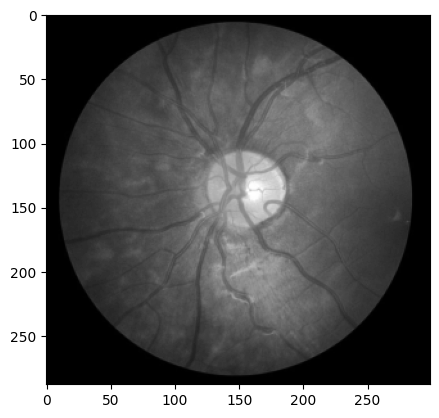

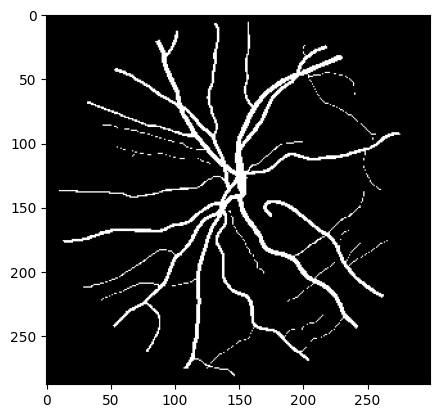

(959, 996)
(959, 996)


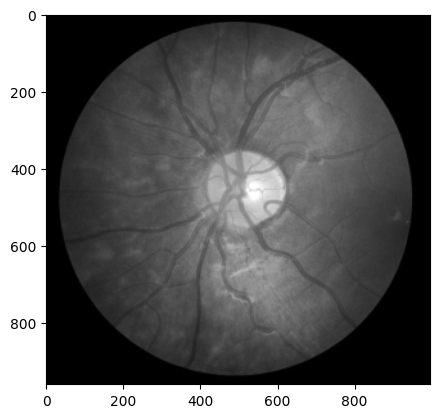

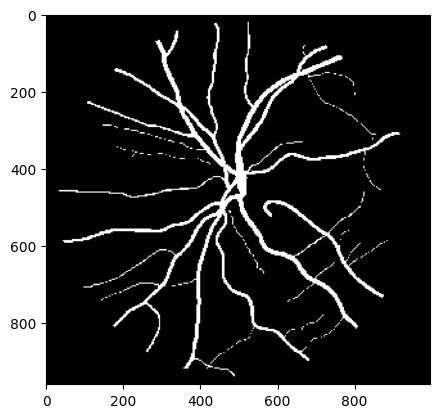

In [21]:
test_image = "IMAGES/Image_01L.jpg"
test_seg = "SEG1/Image_01L_1stHO.png"

img = preprocess_image(test_image)
seg = preprocess_seg_map(test_seg)

print(img.shape)
print(seg.shape)

plt.imshow(img,cmap = 'gray')
plt.show()

plt.imshow(seg, cmap = 'gray')
plt.show()

img_up = upsample_image(img)
seg_up = upsample_image(seg)

print(img_up.shape)
print(seg_up.shape)

plt.imshow(img_up,cmap = 'gray')
plt.show()

plt.imshow(seg_up, cmap = 'gray')
plt.show()